In [4]:
# ----------------------------------------------
# Yolo Keras Hand Detection
# ----------------------------------------------

from datetime import datetime
import numpy as np
import sys, getopt
import cv2
import os
from keras import backend as K
import time

os.environ['KERAS_BACKEND'] = 'tensorflow'

from keras.models import load_model
from keras.preprocessing import image

from matplotlib import pyplot as plt

#YOLOV2
#reference from https://github.com/experiencor/keras-yolo2
# https://github.com/experiencor/keras-yolo2/blob/master/LICENSE


Using TensorFlow backend.


In [5]:
def interpret_output_yolov2(output, img_width, img_height):
	anchors=[0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]

	netout=output
	nb_class=1
	obj_threshold=0.4
	nms_threshold=0.3

	grid_h, grid_w, nb_box = netout.shape[:3]

	size = 4 + nb_class + 1;
	nb_box=5

	netout=netout.reshape(grid_h,grid_w,nb_box,size)

	boxes = []
	
	# decode the output by the network
	netout[..., 4]  = _sigmoid(netout[..., 4])
	netout[..., 5:] = netout[..., 4][..., np.newaxis] * _softmax(netout[..., 5:])
	netout[..., 5:] *= netout[..., 5:] > obj_threshold

	for row in range(grid_h):
		for col in range(grid_w):
			for b in range(nb_box):
				# from 4th element onwards are confidence and class classes
				classes = netout[row,col,b,5:]
				
				if np.sum(classes) > 0:
					# first 4 elements are x, y, w, and h
					x, y, w, h = netout[row,col,b,:4]

					x = (col + _sigmoid(x)) / grid_w # center position, unit: image width
					y = (row + _sigmoid(y)) / grid_h # center position, unit: image height
					w = anchors[2 * b + 0] * np.exp(w) / grid_w # unit: image width
					h = anchors[2 * b + 1] * np.exp(h) / grid_h # unit: image height
					confidence = netout[row,col,b,4]
					
					box = bounding_box(x-w/2, y-h/2, x+w/2, y+h/2, confidence, classes)
					
					boxes.append(box)

	# suppress non-maximal boxes
	for c in range(nb_class):
		sorted_indices = list(reversed(np.argsort([box.classes[c] for box in boxes])))

		for i in range(len(sorted_indices)):
			index_i = sorted_indices[i]
			
			if boxes[index_i].classes[c] == 0: 
				continue
			else:
				for j in range(i+1, len(sorted_indices)):
					index_j = sorted_indices[j]
					
					if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_threshold:
						boxes[index_j].classes[c] = 0
						
	# remove the boxes which are less likely than a obj_threshold
	boxes = [box for box in boxes if box.get_score() > obj_threshold]
	
	result = []
	for i in range(len(boxes)):
		if(boxes[i].classes[0]==0):
			continue
		predicted_class = "hand"
		score = boxes[i].score
		result.append([predicted_class,(boxes[i].xmax+boxes[i].xmin)*img_width/2,(boxes[i].ymax+boxes[i].ymin)*img_height/2,(boxes[i].xmax-boxes[i].xmin)*img_width,(boxes[i].ymax-boxes[i].ymin)*img_height,score])

	return result

class bounding_box:
	def __init__(self, xmin, ymin, xmax, ymax, c = None, classes = None):
		self.xmin = xmin
		self.ymin = ymin
		self.xmax = xmax
		self.ymax = ymax
		
		self.c     = c
		self.classes = classes

		self.label = -1
		self.score = -1

	def get_label(self):
		if self.label == -1:
			self.label = np.argmax(self.classes)
		
		return self.label
	
	def get_score(self):
		if self.score == -1:
			self.score = self.classes[self.get_label()]
			
		return self.score

def bbox_iou(box1, box2):
	intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
	intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])  
	
	intersect = intersect_w * intersect_h

	w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
	w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
	
	union = w1*h1 + w2*h2 - intersect
	
	return float(intersect) / union

def _interval_overlap(interval_a, interval_b):
	x1, x2 = interval_a
	x3, x4 = interval_b

	if x3 < x1:
		if x4 < x1:
			return 0
		else:
			return min(x2,x4) - x1
	else:
		if x2 < x3:
			 return 0
		else:
			return min(x2,x4) - x3          

def _sigmoid(x):
	return 1. / (1. + np.exp(-x))

def _softmax(x, axis=-1, t=-100.):
	x = x - np.max(x)
	
	if np.min(x) < t:
		x = x/np.min(x)*t
		
	e_x = np.exp(x)
	
	return e_x / e_x.sum(axis, keepdims=True)

#crop
def crop(x,y,w,h,margin,img_width,img_height):
	xmin = int(x-w*margin)
	xmax = int(x+w*margin)
	ymin = int(y-h*margin)
	ymax = int(y+h*margin)
	if xmin<0:
		xmin = 0
	if ymin<0:
		ymin = 0
	if xmax>img_width:
		xmax = img_width
	if ymax>img_height:
		ymax = img_height
	return xmin,xmax,ymin,ymax

#display result
def show_results(img,results, img_width, img_height):
	img_cp = img.copy()
	print('len results:',len(results))
	img_cp1 = cv2.cvtColor(img_cp, cv2.COLOR_BGR2RGB)
	for i in range(len(results)):
		x = int(results[i][1])
		y = int(results[i][2])
		w = int(results[i][3])//2
		h = int(results[i][4])//2

		xmin,xmax,ymin,ymax=crop(x,y,w,h,1.0,img_width,img_height)

		cv2.rectangle(img_cp1,(xmin,ymin),(xmax,ymax),(0,255,0), 30)
		cv2.rectangle(img_cp1,(xmin,ymin-20),(xmax,ymin),(125,125,125),-1)
		cv2.putText(img_cp1,results[i][0] + ' : %.2f' % results[i][5],(xmin+5,ymin-7),cv2.FONT_HERSHEY_SIMPLEX,5,(255,0, 0), 10 , cv2.LINE_AA)
	return img_cp1 #cv2.imshow('YoloKerasHandDetection',img_cp)


In [6]:
MODEL_ROOT_PATH="./pretrain/"

#Load Model
model_hand = load_model(MODEL_ROOT_PATH+'yolov2_tiny-hand.h5')

/root/team3/yes/envs/YoloKeras/lib/python3.6/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


1591512647.5181777
prediction time: 0.3836708068847656
len results: 1


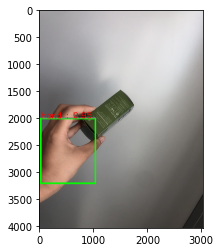

In [7]:

img=cv2.imread('./our-dataset/in-the-vanilla/es/KakaoTalk_20200607_152503011.jpg', cv2.IMREAD_COLOR)
img = img[...,::-1]  #BGR 2 RGB
inputs = img.copy() / 255.0

img_cv = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
img_camera = cv2.resize(inputs, (416,416))
img_camera = np.expand_dims(img_camera, axis=0)
start = time.time()
print(start)
out2 = model_hand.predict(img_camera)[0]
end = time.time()
print('prediction time:',end-start)
results = interpret_output_yolov2(out2, img.shape[1], img.shape[0])

#Age and Gender Detection
img_cp=show_results(img_cv,results, img.shape[1], img.shape[0])
plt.imshow(img_cp)
plt.imsave('save.png',img_cp)


In [8]:
from os import listdir
from os.path import isfile, join

target_dir = './our-dataset/in-the-vanilla/es/'
files = [f for f in listdir(target_dir) if isfile(join(target_dir, f))]
print(files)

['KakaoTalk_20200607_152510820_07.jpg', 'KakaoTalk_20200607_152510820_06.jpg', 'KakaoTalk_20200607_152424504_12.jpg', 'KakaoTalk_20200607_152503011_07.jpg', 'KakaoTalk_20200607_152503011_09.jpg', 'KakaoTalk_20200607_152424504_04.jpg', 'KakaoTalk_20200607_152503011_06.jpg', 'KakaoTalk_20200607_152424504_09.jpg', 'KakaoTalk_20200607_152424504_19.jpg', 'KakaoTalk_20200607_152510820_05.jpg', 'KakaoTalk_20200607_152503011_13.jpg', 'KakaoTalk_20200607_152424504_23.jpg', 'KakaoTalk_20200607_152424504.jpg', 'KakaoTalk_20200607_152503011_03.jpg', 'KakaoTalk_20200607_152424504_05.jpg', 'KakaoTalk_20200607_152424504_24.jpg', 'KakaoTalk_20200607_152424504_16.jpg', 'KakaoTalk_20200607_152503011.jpg', 'KakaoTalk_20200607_152503011_10.jpg', 'KakaoTalk_20200607_152424504_06.jpg', 'KakaoTalk_20200607_152424504_10.jpg', 'KakaoTalk_20200607_152503011_15.jpg', 'KakaoTalk_20200607_152503011_11.jpg', 'KakaoTalk_20200607_152503011_08.jpg', 'KakaoTalk_20200607_152510820_01.jpg', 'KakaoTalk_20200607_152424504_

In [31]:
def get_result(img_path,img_name, dst_dir):
  file_name = os.path.join(dst_dir,img_name[:-4]+'_result.png')
  img=cv2.imread(img_path, cv2.IMREAD_COLOR)
  img = img[...,::-1]  #BGR 2 RGB
  inputs = img.copy() / 255.0
  
  img_cv = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  img_camera = cv2.resize(inputs, (416,416))
  img_camera = np.expand_dims(img_camera, axis=0)
  start = time.time()
  out2 = model_hand.predict(img_camera)[0]
  end = time.time()
  print('prediction time:',end-start)
  start = time.time()
  results = interpret_output_yolov2(out2, img.shape[1], img.shape[0])
  end = time.time()
  print('interpret time:',end-start)

  #Age and Gender Detection
  img_cp=show_results(img_cv,results, img.shape[1], img.shape[0])
  # plt.imshow(img_cp)
  print(file_name)
  plt.imsave(file_name,img_cp)

prediction time: 0.11124515533447266
interpret time: 0.0067195892333984375
len results: 2
./result/5_result.png


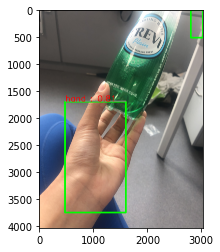

In [10]:
get_result('./hand/5.jpg','5.jpg','./result')

['B1_PS_H_test_000089.jpg', 'B1_PS_H_test_000004.jpg', 'B1_PS_H_test_000087.jpg', 'B1_PS_H_test_000064.jpg', 'B1_PS_H_test_000050.jpg', 'B1_PS_H_test_000020.jpg', 'B1_PS_H_test_000094.jpg', 'B1_PS_H_test_000015.jpg', 'B1_PS_H_test_000012.jpg', 'B1_PS_H_test_000069.jpg', 'B1_PS_H_test_000053.jpg', 'B1_PS_H_test_000040.jpg', 'B1_PS_H_test_000013.jpg', 'B1_PS_H_test_000083.jpg', 'B1_PS_H_test_000084.jpg', 'B1_PS_H_test_000085.jpg', 'B1_PS_H_test_000045.jpg', 'B1_PS_H_test_000018.jpg', 'B1_PS_H_test_000076.jpg', 'B1_PS_H_test_000049.jpg', 'B1_PS_H_test_000081.jpg', 'B1_PS_H_test_000057.jpg', 'B1_PS_H_test_000034.jpg', 'B1_PS_H_test_000088.jpg', 'B1_PS_H_test_000046.jpg', 'B1_PS_H_test_000043.jpg', 'B1_PS_H_test_000019.jpg', 'B1_PS_H_test_000029.jpg', 'B1_PS_H_test_000021.jpg', 'B1_PS_H_test_000070.jpg', 'B1_PS_H_test_000060.jpg', 'B1_PS_H_test_000065.jpg', 'B1_PS_H_test_000024.jpg', 'B1_PS_H_test_000059.jpg', 'B1_PS_H_test_000062.jpg', 'B1_PS_H_test_000009.jpg', 'B1_PS_H_test_000032.jpg', 

prediction time: 0.09347677230834961
interpret time: 0.007002353668212891
len results: 3
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-wild/B1_PS_H_test/B1_PS_H_test_000029_result.png
prediction time: 0.09294414520263672
interpret time: 0.007036685943603516
len results: 1
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-wild/B1_PS_H_test/B1_PS_H_test_000021_result.png
prediction time: 0.0947115421295166
interpret time: 0.006630897521972656
len results: 2
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-wild/B1_PS_H_test/B1_PS_H_test_000070_result.png
prediction time: 0.10608959197998047
interpret time: 0.006958484649658203
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-wild/B1_PS_H_test/B1_PS_H_test_000060_result.png
prediction time: 0.08852791786193848
interpret time: 0.0070018768310546875
len results: 1
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-wild

prediction time: 0.0952155590057373
interpret time: 0.007021188735961914
len results: 1
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-wild/B1_PS_H_test/B1_PS_H_test_000010_result.png
prediction time: 0.09727668762207031
interpret time: 0.0065310001373291016
len results: 1
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-wild/B1_PS_H_test/B1_PS_H_test_000023_result.png
prediction time: 0.09368777275085449
interpret time: 0.0065038204193115234
len results: 1
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-wild/B1_PS_H_test/B1_PS_H_test_000082_result.png
prediction time: 0.09053421020507812
interpret time: 0.007067203521728516
len results: 1
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-wild/B1_PS_H_test/B1_PS_H_test_000035_result.png
prediction time: 0.0902853012084961
interpret time: 0.00646662712097168
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-wild/

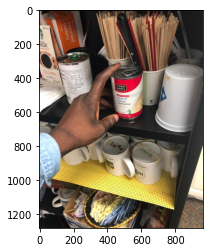

In [12]:
# img_path,img_name, dst_dir
PWD = os.getcwd()
target_dir = './TEgO/Testing/Images/in-the-wild/B1_PS_H_test/'
dst_dir_sangdae = 'TEgO_result/Testing/Images/in-the-wild/B1_PS_H_test/'

dst_dir = os.path.join(PWD ,dst_dir_sangdae)

if not os.path.isdir(dst_dir):
    os.makedirs(dst_dir)

files = [f for f in listdir(target_dir) if isfile(join(target_dir, f))]
print(files)

for i in files:
   file_name = os.path.join(target_dir,i)
   get_result(file_name, i,dst_dir )

/root/Edwin/hand-detection-YoloKeras
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test/
['S1_PS_H_test_000050.jpg', 'S1_PS_H_test_000066.jpg', 'S1_PS_H_test_000068.jpg', 'S1_PS_H_test_000081.jpg', 'S1_PS_H_test_000039.jpg', 'S1_PS_H_test_000015.jpg', 'S1_PS_H_test_000089.jpg', 'S1_PS_H_test_000047.jpg', 'S1_PS_H_test_000018.jpg', 'S1_PS_H_test_000058.jpg', 'S1_PS_H_test_000044.jpg', 'S1_PS_H_test_000077.jpg', 'S1_PS_H_test_000071.jpg', 'S1_PS_H_test_000090.jpg', 'S1_PS_H_test_000026.jpg', 'S1_PS_H_test_000004.jpg', 'S1_PS_H_test_000048.jpg', 'S1_PS_H_test_000036.jpg', 'S1_PS_H_test_000094.jpg', 'S1_PS_H_test_000033.jpg', 'S1_PS_H_test_000010.jpg', 'S1_PS_H_test_000042.jpg', 'S1_PS_H_test_000009.jpg', 'S1_PS_H_test_000052.jpg', 'S1_PS_H_test_000063.jpg', 'S1_PS_H_test_000031.jpg', 'S1_PS_H_test_000054.jpg', 'S1_PS_H_test_000014.jpg', 'S1_PS_H_test_000085.jpg', 'S1_PS_H_test_000041.jpg', 'S1_PS_H_test_000062.jpg', 'S1_PS_H_test_000092.jpg', 'S1_P

prediction time: 0.10171723365783691
interpret time: 0.00692439079284668
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test/S1_PS_H_test_000054_result.png
prediction time: 0.10159182548522949
interpret time: 0.0067555904388427734
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test/S1_PS_H_test_000014_result.png
prediction time: 0.10356783866882324
interpret time: 0.0063512325286865234
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test/S1_PS_H_test_000085_result.png
prediction time: 0.10396361351013184
interpret time: 0.006714344024658203
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test/S1_PS_H_test_000041_result.png
prediction time: 0.10482931137084961
interpret time: 0.0064203739166259766
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Imag

prediction time: 0.10206818580627441
interpret time: 0.006887912750244141
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test/S1_PS_H_test_000091_result.png
prediction time: 0.10302186012268066
interpret time: 0.006397247314453125
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test/S1_PS_H_test_000080_result.png
prediction time: 0.10261225700378418
interpret time: 0.0068624019622802734
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test/S1_PS_H_test_000073_result.png
prediction time: 0.10391521453857422
interpret time: 0.006855010986328125
len results: 1
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test/S1_PS_H_test_000022_result.png
prediction time: 0.1025843620300293
interpret time: 0.006684064865112305
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images

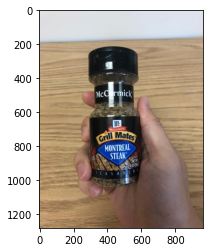

In [7]:
# img_path,img_name, dst_dir
PWD = os.getcwd()
print(PWD)
target_dir = 'TEgO/Testing/Images/in-the-vanilla/S1_PS_H_test/'
dst_dir_sangdae = 'TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test/'

target_dir = os.path.join(PWD ,target_dir)
dst_dir = os.path.join(PWD ,dst_dir_sangdae)
print(dst_dir)
if not os.path.isdir(dst_dir):
    os.makedirs(dst_dir)

files = [f for f in listdir(target_dir) if isfile(join(target_dir, f))]
print(files)

for i in files:
   file_name = os.path.join(target_dir,i)
   get_result(file_name, i,dst_dir )

In [12]:
import os

def experiment(target_subdir,dst_dir):
    
    if not os.path.isdir(dst_dir):
        os.makedirs(dst_dir)

    files = [f for f in os.listdir(target_subdir) if os.path.isfile(os.path.join(target_subdir, f))]
    print(files)

    for i in files:
       file_name = os.path.join(target_subdir,i)
       get_result(file_name, i,dst_dir )


In [24]:
PWD = os.getcwd()
target_str = 'our-dataset/in-the-vanilla/'
dst_dir_str = 'our-dataset-result/in-the-vanilla/'
target_dir = os.path.join(PWD ,target_str)
dst_dir_str = os.path.join(PWD ,dst_dir_str)
a = os.listdir(target_dir)

In [25]:
print(a)

['jh', '.ipynb_checkpoints', 'sh', 'es']


In [27]:
print(target_dir)
print(dst_dir_str)
target_subdirs = [os.path.join(target_dir, direc) for direc in a]
dst_subdirs = [os.path.join(dst_dir_str, direc) for direc in a]


/root/Edwin/hand-detection-YoloKeras/our-dataset/in-the-vanilla/
/root/Edwin/hand-detection-YoloKeras/our-dataset-result/in-the-vanilla/


In [28]:
print(target_subdirs)

['/root/Edwin/hand-detection-YoloKeras/our-dataset/in-the-vanilla/jh', '/root/Edwin/hand-detection-YoloKeras/our-dataset/in-the-vanilla/.ipynb_checkpoints', '/root/Edwin/hand-detection-YoloKeras/our-dataset/in-the-vanilla/sh', '/root/Edwin/hand-detection-YoloKeras/our-dataset/in-the-vanilla/es']


In [29]:
print(dst_subdirs)

['/root/Edwin/hand-detection-YoloKeras/our-dataset-result/in-the-vanilla/jh', '/root/Edwin/hand-detection-YoloKeras/our-dataset-result/in-the-vanilla/.ipynb_checkpoints', '/root/Edwin/hand-detection-YoloKeras/our-dataset-result/in-the-vanilla/sh', '/root/Edwin/hand-detection-YoloKeras/our-dataset-result/in-the-vanilla/es']


['KakaoTalk_20200607_000047006_24.jpg', 'KakaoTalk_20200607_000047006_01.jpg', 'KakaoTalk_20200607_000047006_11.jpg', 'KakaoTalk_20200607_000047006_13.jpg', 'KakaoTalk_20200607_000406128_01.jpg', 'KakaoTalk_20200607_000047006_12.jpg', 'KakaoTalk_20200607_000047006_15.jpg', 'KakaoTalk_20200607_000047006_22.jpg', 'KakaoTalk_20200607_000047006_26.jpg', 'KakaoTalk_20200607_000049287_03.jpg', 'KakaoTalk_20200607_000047006_23.jpg', 'KakaoTalk_20200607_000047006_14.jpg', 'KakaoTalk_20200607_000047006_04.jpg', 'KakaoTalk_20200607_000047006_25.jpg', 'KakaoTalk_20200607_000047006_09.jpg', 'KakaoTalk_20200607_000406128_02.jpg', 'KakaoTalk_20200607_000047006_10.jpg', 'KakaoTalk_20200607_000047006_02.jpg', 'KakaoTalk_20200607_000047006_08.jpg', 'KakaoTalk_20200607_000047006_16.jpg', 'KakaoTalk_20200607_000406128_04.jpg', 'KakaoTalk_20200607_000049287_02.jpg', 'KakaoTalk_20200607_000047006_28.jpg', 'KakaoTalk_20200607_000047006_05.jpg', 'KakaoTalk_20200607_000406128_08.jpg', 'KakaoTalk_20200607_0004

prediction time: 0.10105562210083008
interpret time: 0.007294893264770508
len results: 2
/root/Edwin/hand-detection-YoloKeras/our-dataset-result/in-the-vanilla/sh/KakaoTalk_20200607_000406128_result.png
prediction time: 0.1014871597290039
interpret time: 0.006674051284790039
len results: 1
/root/Edwin/hand-detection-YoloKeras/our-dataset-result/in-the-vanilla/sh/KakaoTalk_20200607_000047006_03_result.png
prediction time: 0.100341796875
interpret time: 0.006750345230102539
len results: 0
/root/Edwin/hand-detection-YoloKeras/our-dataset-result/in-the-vanilla/sh/KakaoTalk_20200607_000047006_18_result.png
prediction time: 0.10191965103149414
interpret time: 0.00674748420715332
len results: 0
/root/Edwin/hand-detection-YoloKeras/our-dataset-result/in-the-vanilla/sh/KakaoTalk_20200607_000047006_result.png
prediction time: 0.10267472267150879
interpret time: 0.007202863693237305
len results: 0
/root/Edwin/hand-detection-YoloKeras/our-dataset-result/in-the-vanilla/sh/KakaoTalk_20200607_0004061

prediction time: 0.10367822647094727
interpret time: 0.00673675537109375
len results: 0
/root/Edwin/hand-detection-YoloKeras/our-dataset-result/in-the-vanilla/es/KakaoTalk_20200607_152503011_10_result.png
prediction time: 0.10310077667236328
interpret time: 0.007222414016723633
len results: 2
/root/Edwin/hand-detection-YoloKeras/our-dataset-result/in-the-vanilla/es/KakaoTalk_20200607_152424504_06_result.png
prediction time: 0.10114765167236328
interpret time: 0.007162332534790039
len results: 0
/root/Edwin/hand-detection-YoloKeras/our-dataset-result/in-the-vanilla/es/KakaoTalk_20200607_152424504_10_result.png
prediction time: 0.10028600692749023
interpret time: 0.006921052932739258
len results: 2
/root/Edwin/hand-detection-YoloKeras/our-dataset-result/in-the-vanilla/es/KakaoTalk_20200607_152503011_15_result.png
prediction time: 0.10642623901367188
interpret time: 0.007152557373046875
len results: 0
/root/Edwin/hand-detection-YoloKeras/our-dataset-result/in-the-vanilla/es/KakaoTalk_2020

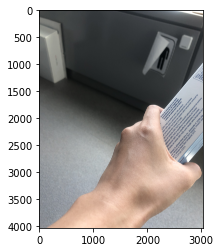

In [23]:
for i in range(len(target_subdirs)):
    experiment(target_subdirs[i],dst_subdirs[i])

['IMG_4324.jpg', 'IMG_4300.jpg', 'IMG_4358.jpg', 'IMG_4341.jpg', 'IMG_4321.jpg', 'IMG_4305.jpg', 'IMG_4318.jpg', 'IMG_4316.jpg', 'IMG_4348.jpg', 'IMG_4353.jpg', 'IMG_4302.jpg', 'IMG_4354.jpg', 'IMG_4333.jpg', 'IMG_4336.jpg', 'IMG_4338.jpg', 'IMG_4360.jpg', 'IMG_4335.jpg', 'IMG_4309.jpg', 'IMG_4343.jpg', 'IMG_4288.jpg', 'IMG_4332.jpg', 'IMG_4355.jpg', 'IMG_4295.jpg', 'IMG_4303.jpg', 'IMG_4289.jpg', 'IMG_4301.jpg', 'IMG_4312.jpg', 'IMG_4327.jpg', 'IMG_4285.jpg', 'IMG_4319.jpg', 'IMG_4290.jpg', 'IMG_4291.jpg', 'IMG_4306.jpg', 'IMG_4287.jpg', 'IMG_4339.jpg', 'IMG_4310.jpg', 'IMG_4331.jpg', 'IMG_4314.jpg', 'IMG_4334.jpg', 'IMG_4350.jpg', 'IMG_4337.jpg', 'IMG_4294.jpg', 'IMG_4299.jpg', 'IMG_4311.jpg', 'IMG_4313.jpg', 'IMG_4347.jpg', 'IMG_4296.jpg', 'IMG_4304.jpg', 'IMG_4349.jpg', 'IMG_4326.jpg', 'IMG_4340.jpg', 'IMG_4292.jpg', 'IMG_4357.jpg', 'IMG_4359.jpg', 'IMG_4323.jpg', 'IMG_4322.jpg', 'IMG_4352.jpg', 'IMG_4328.jpg', 'IMG_4293.jpg', 'IMG_4345.jpg', 'IMG_4298.jpg', 'IMG_4315.jpg', 'IMG_43

prediction time: 0.10432553291320801
interpret time: 0.007305622100830078
len results: 2
/root/Edwin/hand-detection-YoloKeras/our-dataset-result/in-the-vanilla/jh/IMG_4350_result.png
prediction time: 0.1040036678314209
interpret time: 0.007232666015625
len results: 2
/root/Edwin/hand-detection-YoloKeras/our-dataset-result/in-the-vanilla/jh/IMG_4337_result.png
prediction time: 0.10876798629760742
interpret time: 0.0071141719818115234
len results: 0
/root/Edwin/hand-detection-YoloKeras/our-dataset-result/in-the-vanilla/jh/IMG_4294_result.png
prediction time: 0.10838031768798828
interpret time: 0.007060527801513672
len results: 0
/root/Edwin/hand-detection-YoloKeras/our-dataset-result/in-the-vanilla/jh/IMG_4299_result.png
prediction time: 0.10508847236633301
interpret time: 0.006574869155883789
len results: 0
/root/Edwin/hand-detection-YoloKeras/our-dataset-result/in-the-vanilla/jh/IMG_4311_result.png
prediction time: 0.1125175952911377
interpret time: 0.006681919097900391
len results: 0


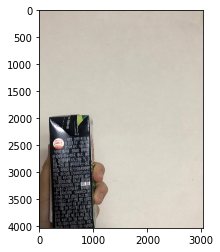

In [30]:
experiment(target_subdirs[0],dst_subdirs[0])